In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
import sys
import bcolz
import random


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


dog-breed-identification
keras-pretrained-models



First we will read in the csv's so we can see some more information on the filenames and breeds

In [2]:
df_train = pd.read_csv('../input/dog-breed-identification/labels.csv')
df_test = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [3]:
df_train.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
train_files = glob('../input/dog-breed-identification/train/*.jpg')
test_files = glob('../input/dog-breed-identification/test/*.jpg')

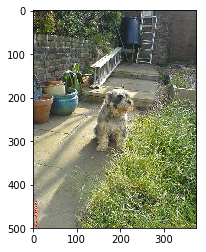

In [6]:
plt.imshow(plt.imread(train_files[150]))

Next we will read in all of the images for test and train, using a for loop through the values of the csv files. I have also set an im_size variable which sets the size for the image to be re-sized to,  90x90 px, you should play with this number to see how it affects accuracy.

In [8]:
im_size = 300

In [9]:
y_train = []
y_val = []
x_train_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)
x_val_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)

In [12]:
y_train_raw = np.array(y_train, np.uint8)
y_val_raw = np.array(y_val, np.uint8)
del(y_train,y_val)
import gc
gc.collect()

32

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, im_size = 300, batch_size=2, shuffle=True, data_augment = False, test = False):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = np.arange(0,data.shape[0])
        self.shuffle = shuffle
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)        
        self.data = data
        self.data_augment = data_augment
        self.test = test
        if self.test == False:
            self.labels = labels
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        if self.test == False:
            X, y = self.__data_generation(indexes)
            return preprocess_input(X), y
        else:
            X = self.__data_generation(indexes)
            return preprocess_input(X)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)        

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((list_IDs_temp.shape[0],im_size,im_size,3), dtype=np.float32)
        if self.test == False:
            y = np.zeros((list_IDs_temp.shape[0],self.labels.shape[1]), dtype=np.uint8)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            if self.data_augment == True:
                if random.randint(1,101) < 50: 
                    flip_horizontal = True
                else:
                    flip_horizontal = False
                if random.randint(1,101) < 50: 
                    flip_vertical = True
                else:
                    flip_vertical = False
                tx = im_size*0.8/100.0
                ty = im_size*0.8/100.0
                shear = random.randint(1,10)/100.0
                zx = random.randint(80,120)/100.0
                zy = random.randint(80,120)/100.0
                brightness = random.randint(1,2)/100.0
                channel_shift_intensity = random.randint(1,10)/100.0
                
                X[i,] = self.data[ID,]
            else:
                # Store sample
                X[i,] = self.data[ID,]

            # Store class
            if self.test == False:
                y[i,] = self.labels[ID,]

        if self.test == False:
            return X, y
        else:
            return X

In [16]:
batch_size = 2

# Parameters
params_trn = {
          'im_size': im_size,
          'batch_size': batch_size,
          'shuffle': True,
          'data_augment' : True,
          'test' : False
         }
params_val = {
          'im_size': im_size,
          'batch_size': batch_size,
          'shuffle': True,
          'data_augment' : False,
          'test' : False
         }

# Generators
training_generator = DataGenerator(x_train_raw, y_train_raw, **params_trn)
validation_generator = DataGenerator(x_val_raw, y_val_raw, **params_val)